In [1]:
import pyspark as ps
import pyspark.sql.functions as funcs
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from itertools import combinations

spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [2]:
def splitName(df, name = 'name',delim = ', '):
    split_col = funcs.split(df[name], delim)
    df = df.withColumn('State', split_col.getItem(0))
    df = df.withColumn('County', split_col.getItem(1))
    return df

In [3]:
dataD25 = spark.read.csv('data/Model_11.2.1_20201225_data.csv', header = True, comment = '#', inferSchema = True)
dataD25 = splitName(dataD25)
resultsD25 = spark.read.csv('data/Model_11.2.1_20201225_results.csv', header = True, comment = '#', inferSchema = True)
resultsD25 = splitName(resultsD25, name = 'Name')
dataJ01 = spark.read.csv('data/Model_11.2.1_20210101_data.csv', header = True, comment = '#', inferSchema = True)
dataJ01 = splitName(dataJ01)
resultsJ01 = spark.read.csv('data/Model_11.2.1_20210101_results.csv', header = True, comment = '#', inferSchema = True)
resultsJ01 = splitName(resultsJ01, name = 'Name')
dataJ15 = spark.read.csv('data/Model_11.2.1_20210115_data.csv', header = True, comment = '#', inferSchema = True)
dataJ15 = splitName(dataJ15)
resultsJ15 = spark.read.csv('data/Model_11.2.1_20210115_results.csv', header = True, comment = '#', inferSchema = True)
resultsJ15 = splitName(resultsJ15, name = 'Name')

In [4]:
dataD25_df = dataD25.createOrReplaceTempView('dataD25')
resultsD25_df = resultsD25.createOrReplaceTempView('resultsD25')
dataJ01_df = dataJ01.createOrReplaceTempView('dataJ01')
resultsJ01_df = resultsJ01.createOrReplaceTempView('resultsJ01')
dataJ15_df = dataJ15.createOrReplaceTempView('dataJ15')
resultsJ15_df = resultsJ15.createOrReplaceTempView('resultsJ15')

In [5]:
dataJ15.printSchema()

root
 |-- row: integer (nullable = true)
 |-- sid: string (nullable = true)
 |-- casrn: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- Spread: double (nullable = true)
 |-- Sick: double (nullable = true)
 |-- PctCases: double (nullable = true)
 |-- Cases: integer (nullable = true)
 |-- CountyCaseRate: double (nullable = true)
 |-- StateCaseRate: double (nullable = true)
 |-- PctDeaths: double (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- PctDeaths2: double (nullable = true)
 |-- CountyDeathRate: double (nullable = true)
 |-- StateDeathRate: double (nullable = true)
 |-- StatePctTested: double (nullable = true)
 |-- StateTestRate: double (nullable = true)
 |-- SVISocioeconomic: double (nullable = true)
 |-- SVIMinority: double (nullable = true)
 |-- SVIHousing: double (nullable = true)
 |-- PctBeds: double (nullable = true)
 |-- Mobility: double (nullable = true)
 |-- PctNoIns: double (nullable = true)
 |-- PctGE65: double (nullable = true)
 |-- Dayti

In [6]:
resultsJ15.printSchema()

root
 |-- ToxPi Score: double (nullable = true)
 |-- HClust Group: integer (nullable = true)
 |-- KMeans Group: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Infection Rate: Transmissible Cases!25!0xcc3333ff: double (nullable = true)
 |-- Infection Rate: Disease Spread!5!0xe64d4dff: double (nullable = true)
 |-- Pop Concentration: Pop Mobility!10!0x57b757ff: double (nullable = true)
 |-- Pop Concentration: Residential Density!10!0x5ced5cff: double (nullable = true)
 |-- Intervention: Social Distancing!10!0x4258c9ff: double (nullable = true)
 |-- Intervention: Testing!10!0x6079f7ff: double (nullable = true)
 |-- Health & Environment: Pop Demographics!10!0x6b0b9eff: double (nullable = true)
 |-- Health & Environment: Air Pollution!10!0x8e26c4ff: double (nullable = true)
 |-- Health & Environment: Age Distribution!10!0x9a42c8ff: double (nullable = true)
 |-- Health & Environment: Co-morbidities!10!0xb460e0ff: double (nullable = tr

In [7]:
dataJ15.take(1)

[Row(row=1, sid='-86.6441,32.5395', casrn=1001, name='Alabama, Autauga', Spread=0.174384236453202, Sick=15.9169799104333, PctCases=0.0912753367745184, Cases=5075, CountyCaseRate=1.01087308004023, StateCaseRate=1.00905300172201, PctDeaths=0.0108374384236453, Deaths=55, PctDeaths2=0.000989190841891333, CountyDeathRate=1.01370885629547, StateDeathRate=1.02267613693005, StatePctTested=0.409113292883548, StateTestRate=1.00492952282485, SVISocioeconomic=0.3631, SVIMinority=0.5947, SVIHousing=0.3741, PctBeds=0.00152874948292297, Mobility=1733.08, PctNoIns=7.1, PctGE65=14.6, DaytimePopDensity=76.0, PrematureDeath=8128.5911903, Smoking=0.1808155718, AirPollution=11.7, Diabetes=0.111, Traffic=88.457040416, DistancingGrade=5.0, Obesity=0.333, PctBlack=0.1934317728, PctNative=0.0048020719, State='Alabama', County='Autauga')]

In [8]:
def query(sql_query):
    result = spark.sql(sql_query)
    result.show()

In [9]:
def queryToPandas(sql_query):
    result = spark.sql(sql_query)
    asPandas = result.toPandas()
    return asPandas

In [10]:
def pandaPlot(sql_query, name = None, **plotArgs):
    queryToPandas(sql_query).plot(**plotArgs)
    plt.tight_layout()
    if name:
        plt.savefig(name)

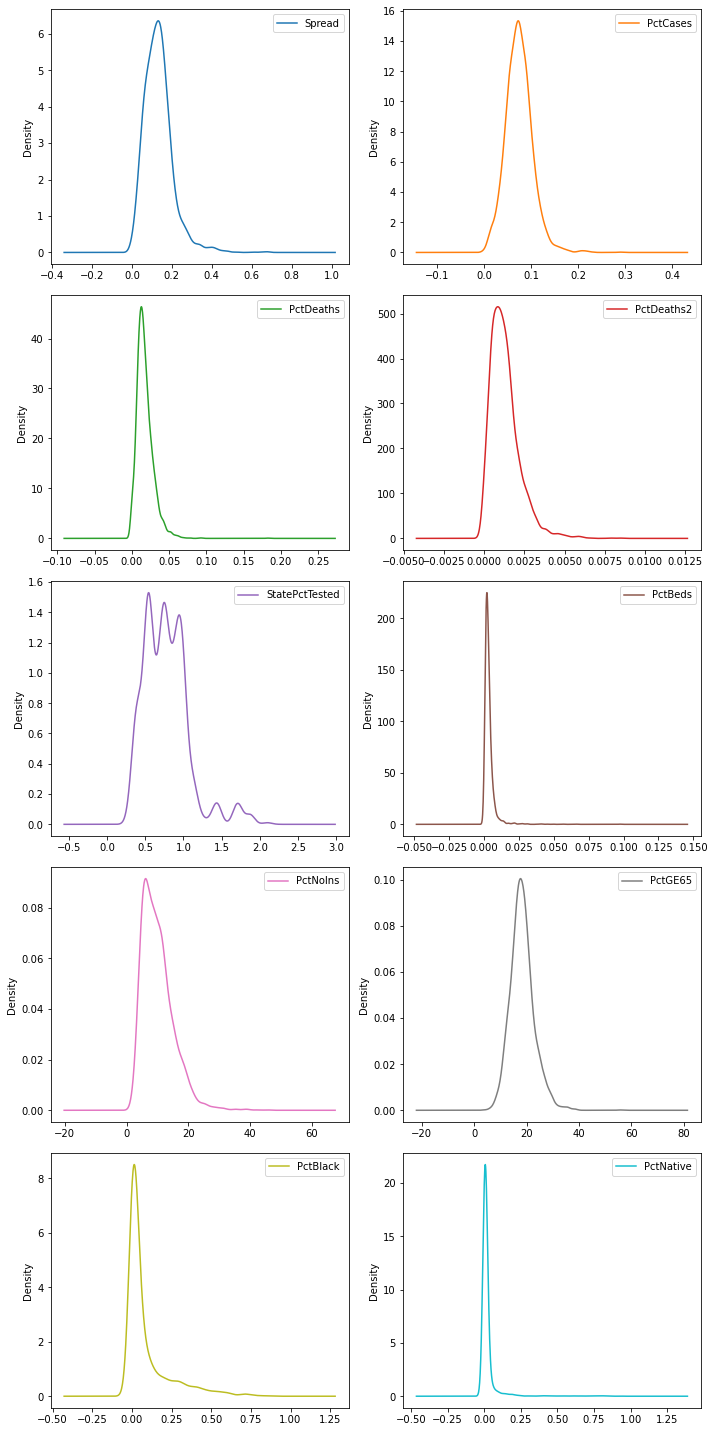

In [11]:
pandaPlot("""
SELECT
    Spread,
    PctCases,
    PctDeaths,
    PctDeaths2,
    StatePctTested,
    PctBeds,
    PctNoIns,
    PctGE65,
    PctBlack,
    PctNative
FROM
    dataJ15
""",**{'sharex':False,'kind' : 'kde', 'subplots': True, 'figsize': (10,20), 'layout':(-1,2)})


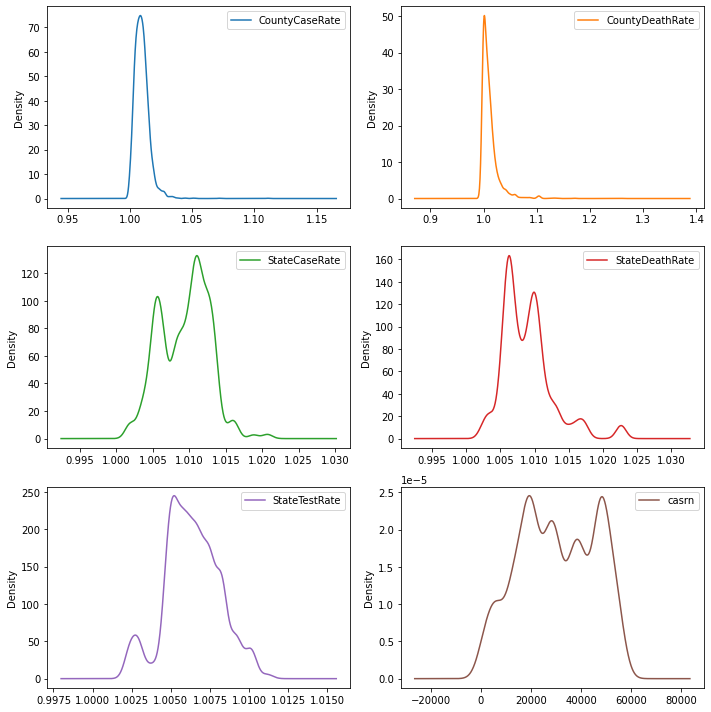

In [12]:
pandaPlot("""
SELECT
    CountyCaseRate,
    CountyDeathRate,
    StateCaseRate,
    StateDeathRate,
    StateTestRate,
    casrn
FROM
    dataJ15
""",**{'sharex':False,'kind' : 'kde', 'subplots': True, 'figsize': (10,10), 'layout':(-1,2)})

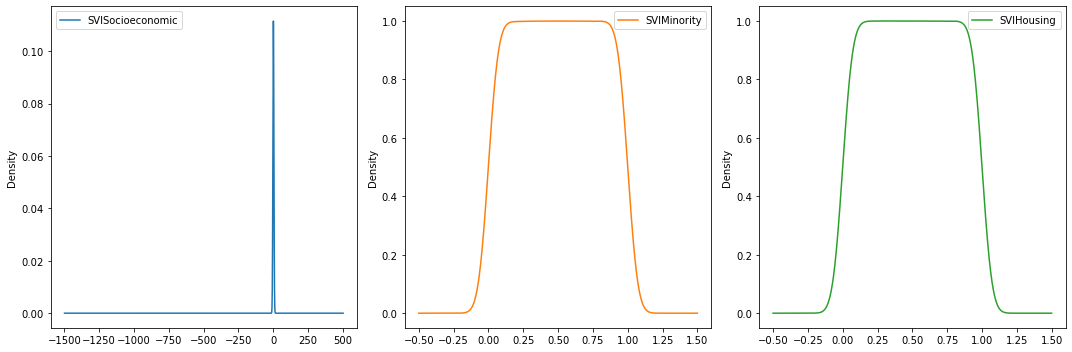

In [13]:
pandaPlot("""
SELECT
    SVISocioeconomic,
    SVIMinority,
    SVIHousing
FROM
    dataJ15
""",**{'sharex':False,'kind' : 'kde', 'subplots': True, 'figsize': (15,5), 'layout':(-1,3)})

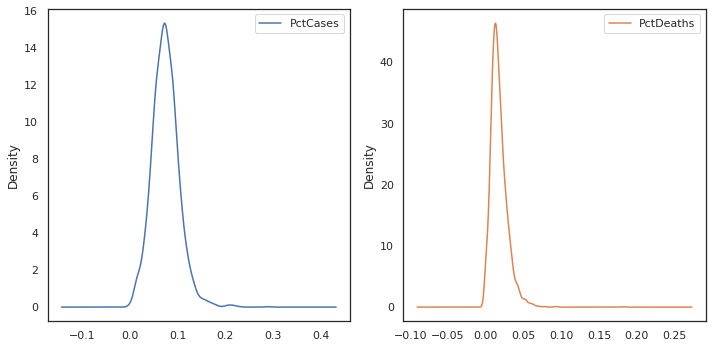

In [84]:
pandaPlot("""
SELECT
    PctCases,
    PctDeaths
FROM
    dataJ15
""",name='isNormal.png',**{'sharex':False,'kind' : 'kde', 'subplots': True, 'figsize': (15,5), 'layout':(-1,3)})

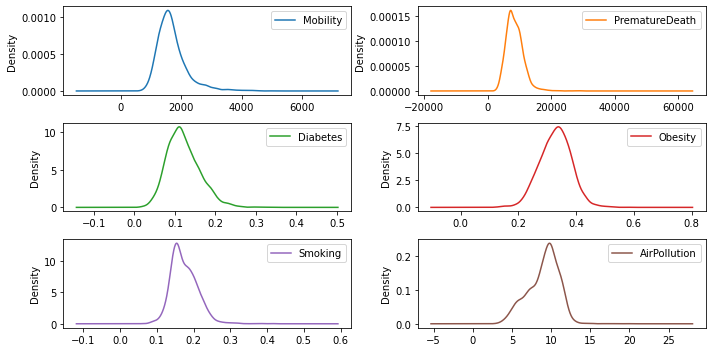

In [15]:
pandaPlot("""
SELECT
    Mobility,
    PrematureDeath,
    Diabetes,
    Obesity,
    Smoking,
    AirPollution
FROM
    dataJ15
""",**{'sharex':False,'kind' : 'kde', 'subplots': True, 'figsize': (10,5), 'layout':(-1,2)})

array([[<AxesSubplot:title={'center':'DistancingGrade'}>]], dtype=object)

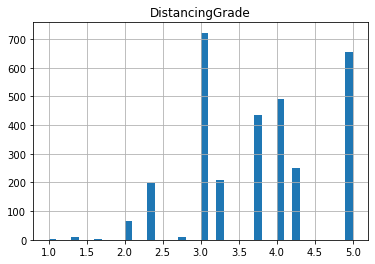

In [16]:
queryToPandas("""
SELECT
    DistancingGrade
FROM
    dataJ15
""").hist(bins = 40)

In [109]:
import folium
from folium import plugins
def map(weight = 'DaytimePopDensity', radius = 25, gradient = {0.1: 'navy', 0.2:'royalblue', 0.3:'cornflowerblue', 0.4:'deepskyblue', 0.5:'mediumspringgreen', 0.6: 'lime', 0.7: 'yellow', 0.8:'orange', 0.9:'orangered', 1: 'red'}):
    map_all=folium.Map(location=[39.8333333, -98.585522],zoom_start = 3.5,tiles = "openstreetmap")
    locations=queryToPandas("""
    SELECT
        sid
    FROM
        dataJ15
    """)['sid'].str.split(',',expand=True)
    locations.columns = ['Longitude','Latitude']
    locations['Weight'] = queryToPandas(f"""
    SELECT
        {weight}
    FROM
        dataJ15
    """).dropna()
    locations = locations[['Latitude','Longitude','Weight']]
    map_all.add_child(plugins.HeatMap(data=locations, radius = radius, gradient = gradient))
    return map_all

In [111]:
map(weight = 'Deaths',radius = 14)

<Figure size 432x288 with 0 Axes>

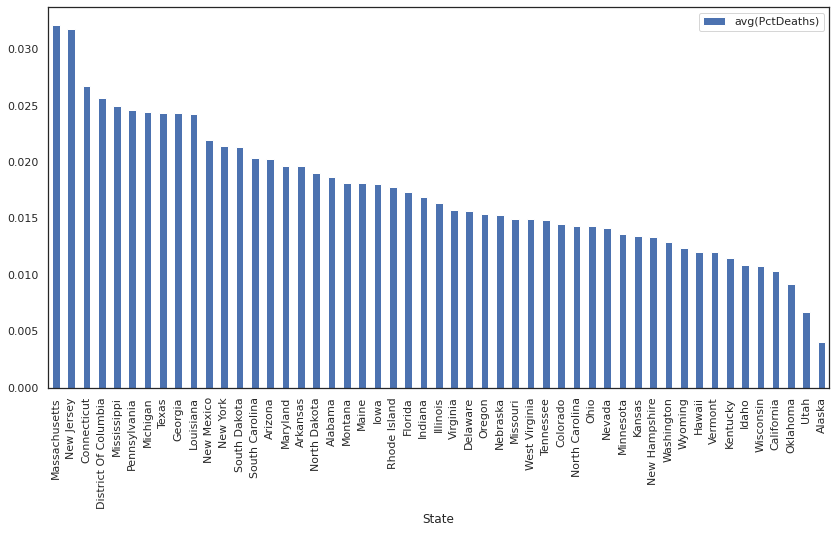

In [121]:
plt.tight_layout()
queryToPandas("""
SELECT
    State,
    AVG(PctDeaths)
FROM
    dataJ15
GROUP BY 
    State
""").set_index('State').sort_values(by='avg(PctDeaths)',ascending=False).plot(kind = 'bar', figsize= (14,7)).get_figure().savefig('AVG%Deaths.png')

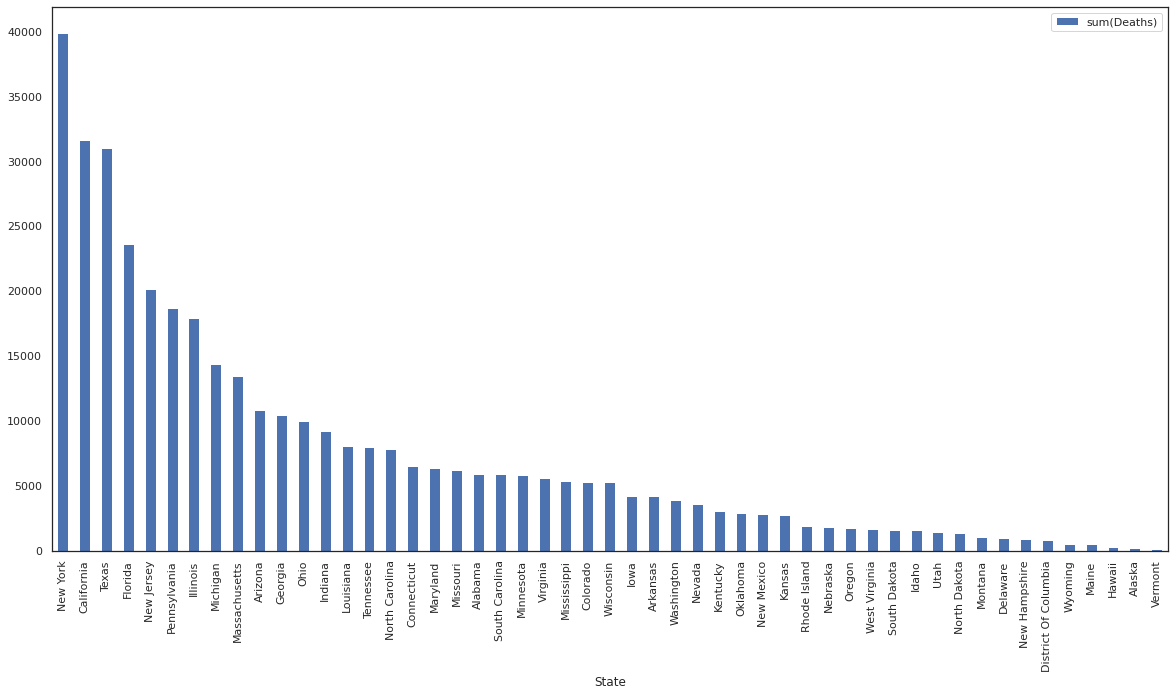

In [113]:
queryToPandas("""
SELECT
    State,
    SUM(Deaths)
FROM
    dataJ15
GROUP BY 
    State
""").set_index('State').sort_values(by='sum(Deaths)',ascending=False).plot(kind = 'bar', figsize= (20,10)).get_figure().savefig('SumDeaths.png')

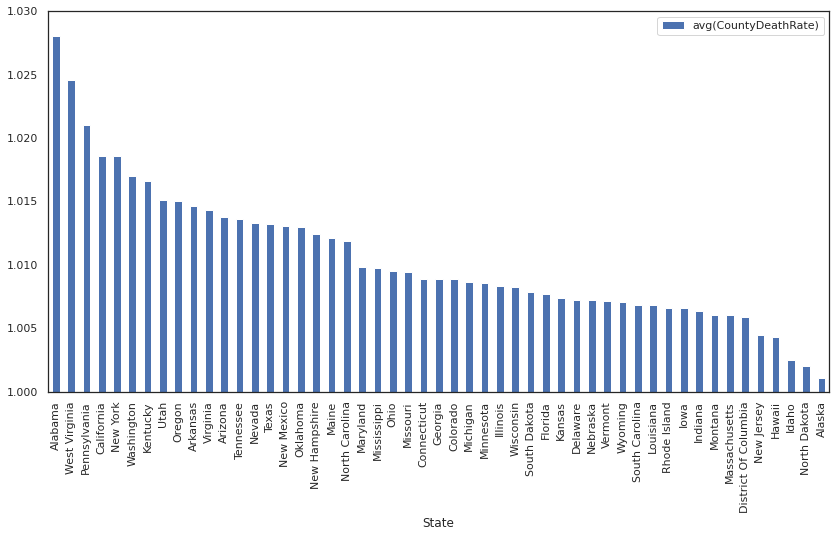

In [123]:
queryToPandas("""
SELECT
    State,
    AVG(CountyDeathRate)
FROM
    dataJ15
GROUP BY 
    State
""").set_index('State').sort_values(by='avg(CountyDeathRate)',ascending=False).plot(kind = 'bar', figsize= (14,7), ylim = ((1,1.03))).get_figure().savefig('AVGCountyDeathRate.png')

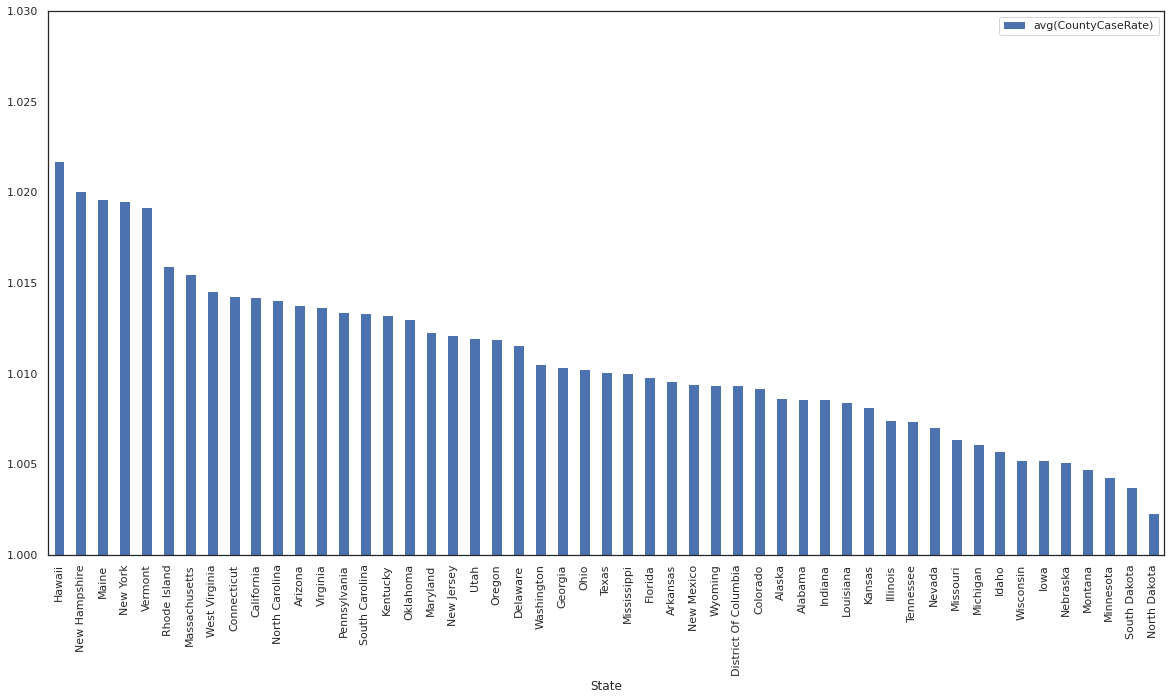

In [115]:
queryToPandas("""
SELECT
    State,
    AVG(CountyCaseRate)
FROM
    dataJ15
GROUP BY 
    State
""").set_index('State').sort_values(by='avg(CountyCaseRate)',ascending=False).plot(kind = 'bar', figsize= (20,10), ylim = ((1,1.03))).get_figure().savefig('AVGCountyCaseRate.png')

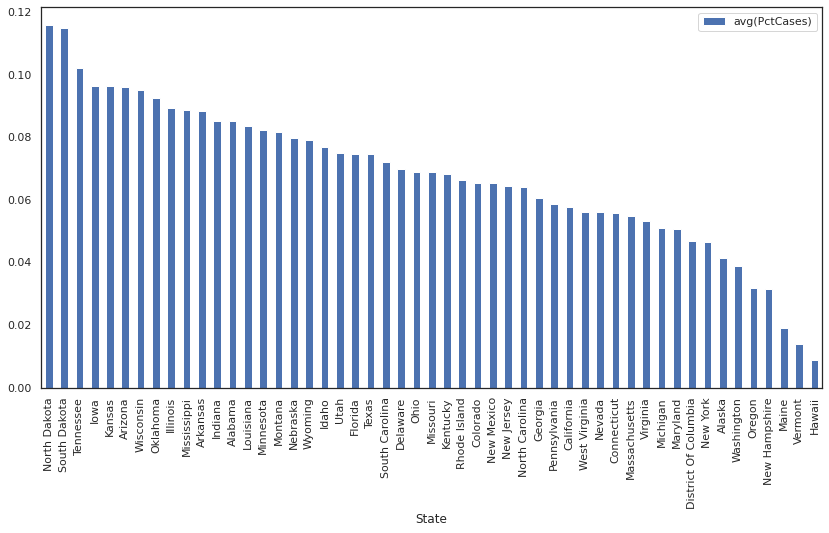

In [122]:
queryToPandas("""
SELECT
    State,
    AVG(PctCases)
FROM
    dataJ15
GROUP BY 
    State
""").set_index('State').sort_values(by='avg(PctCases)',ascending=False).plot(kind = 'bar', figsize= (14,7)).get_figure().savefig('AVG%Cases.png')

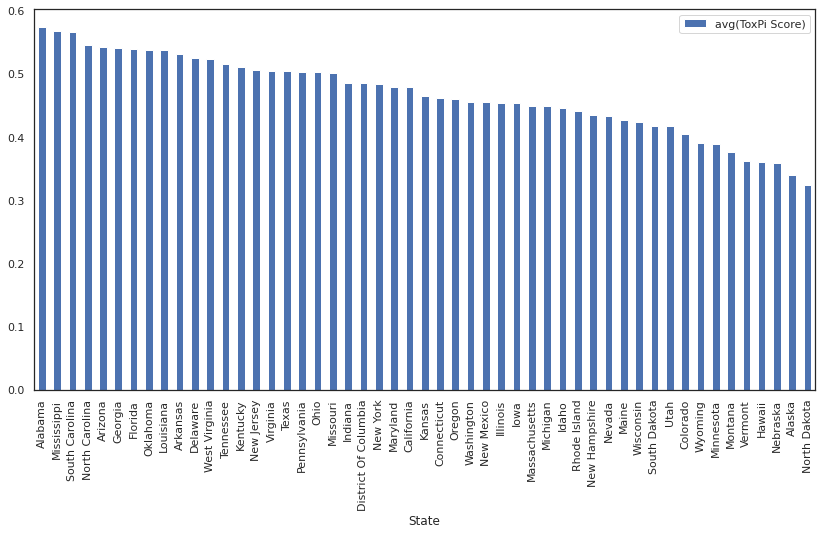

In [124]:
queryToPandas("""
SELECT
    dataJ15.State,
    AVG(`ToxPi Score`)
FROM
    dataJ15
FULL OUTER JOIN
    resultsJ15 ON dataJ15.name = resultsJ15.Name
GROUP BY 
    dataJ15.State
""").set_index('State').sort_values(by='avg(ToxPi Score)',ascending=False).plot(kind = 'bar', figsize= (14,7)).get_figure().savefig('AVGPVI.png')

In [25]:
def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

In [26]:
df = queryToPandas("""
SELECT
    Spread, 
    Sick, 
    PctCases, 
    Cases, 
    CountyCaseRate, 
    StateCaseRate, 
    PctDeaths, 
    Deaths, 
    PctDeaths2, 
    CountyDeathRate, 
    StateDeathRate, 
    StatePctTested, 
    StateTestRate, 
    SVISocioeconomic, 
    SVIMinority, 
    SVIHousing, 
    PctBeds, 
    Mobility, 
    PctNoIns, 
    PctGE65, 
    DaytimePopDensity, 
    PrematureDeath, 
    Smoking, 
    AirPollution, 
    Diabetes, 
    Traffic, 
    DistancingGrade, 
    Obesity, 
    PctBlack, 
    PctNative
FROM
    dataJ15
""")
cronbach_alpha(df)

0.6463829791183092

In [27]:
grouped = {'InfectionRate':['Sick','Spread'],'PopConcentration':['SVIHousing','DaytimePopDensity','Traffic'],'Intervention':['StatePctTested','DistancingGrade'],'Health&Environment':['SVISocioeconomic','PctBeds','PctNoIns','PctGE65','PrematureDeath','Smoking','AirPollution','Diabetes','Obesity','PctBlack','PctNative']}

In [28]:
def getCronbachCombos(k, sig = 0.7):
    from itertools import combinations
    indicators = pd.Series(['Spread', 'Sick', 'PctCases', 'Cases', 'CountyCaseRate', 'StateCaseRate', 
                            'PctDeaths','Deaths', 'PctDeaths2', 'CountyDeathRate', 'StateDeathRate', 'StatePctTested',
                            'StateTestRate', 'SVISocioeconomic', 'SVIMinority', 'SVIHousing', 'PctBeds', 'Mobility',
                            'PctNoIns', 'PctGE65', 'DaytimePopDensity', 'PrematureDeath', 'Smoking', 'AirPollution', 
                            'Diabetes', 'Traffic', 'DistancingGrade', 'Obesity', 'PctBlack', 'PctNative'])
    good = {}
    for tupl in combinations(range(30),k):
        fields = list(indicators[list(tupl)])
        alpha = cronbach_alpha(df[fields])
        if (alpha >= sig):
            good[tuple(fields)]=alpha
    return good

In [29]:
cronbach_alpha(df[grouped['InfectionRate']])

0.8091354004545548

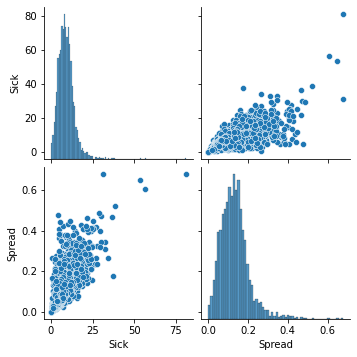

In [30]:
sns.pairplot(df[grouped['InfectionRate']])

In [31]:
cronbach_alpha(df[grouped['PopConcentration']])

0.5029474051859606

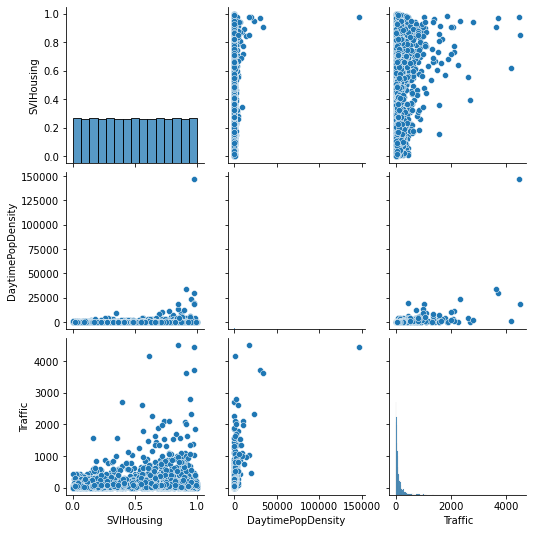

In [32]:
sns.pairplot(df[grouped['PopConcentration']])

In [33]:
cronbach_alpha(df[grouped['Intervention']])

-0.23077664239047577

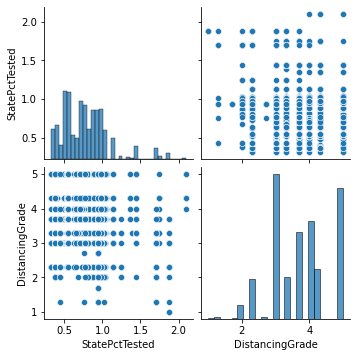

In [34]:
sns.pairplot(df[grouped['Intervention']])

In [35]:
cronbach_alpha(df[grouped['Health&Environment']])

0.6075265399117283

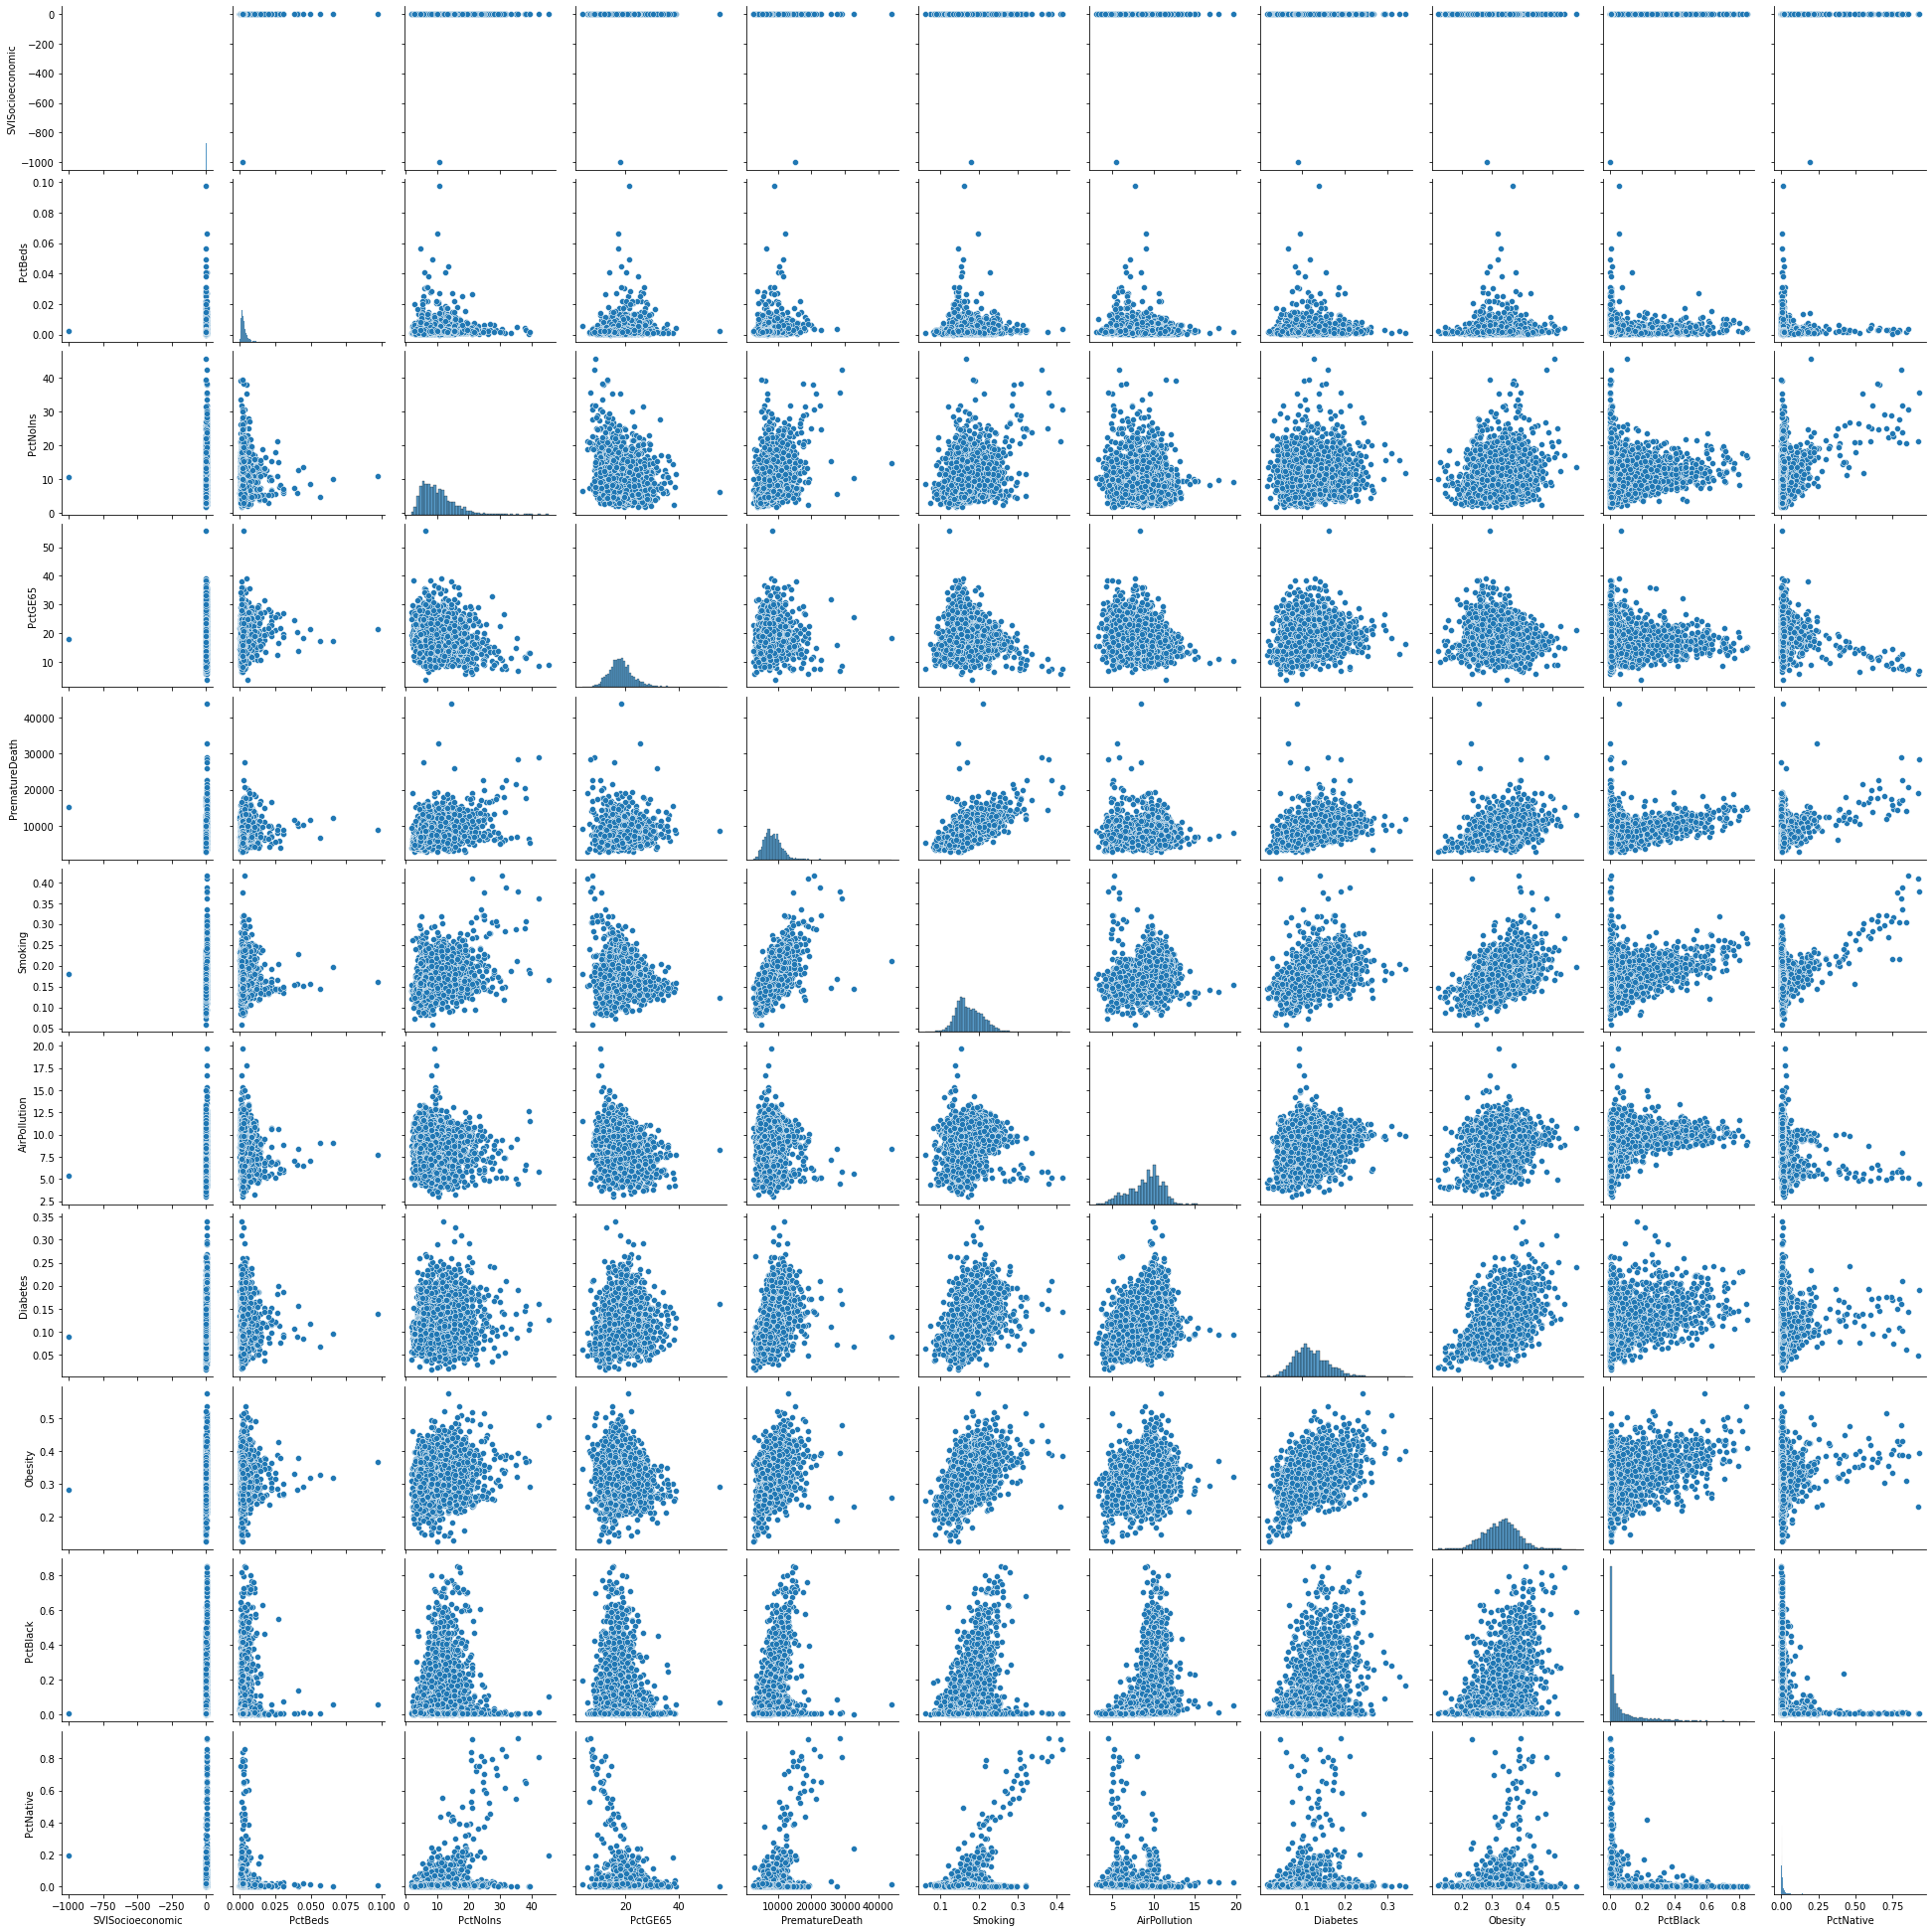

In [36]:
sns.pairplot(df[grouped['Health&Environment']])

In [37]:
def heatmap(df):
    sns.set_theme(style="white")
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

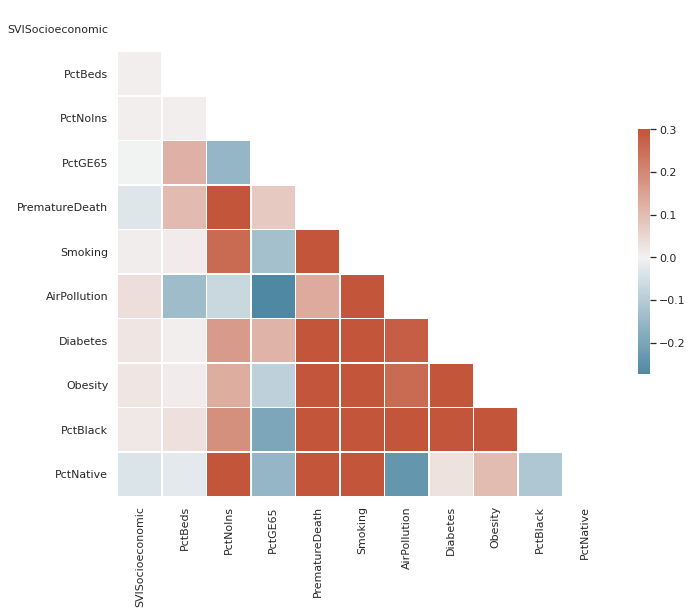

In [38]:
heatmap(df[grouped['Health&Environment']])

<AxesSubplot:>

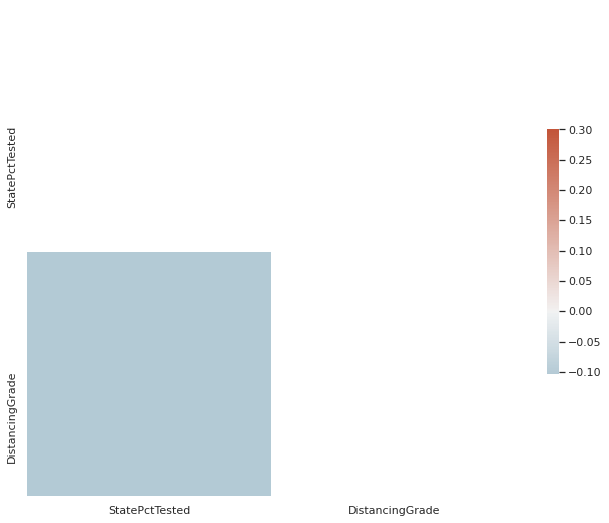

In [39]:
heatmap(df[grouped['Intervention']])

<AxesSubplot:>

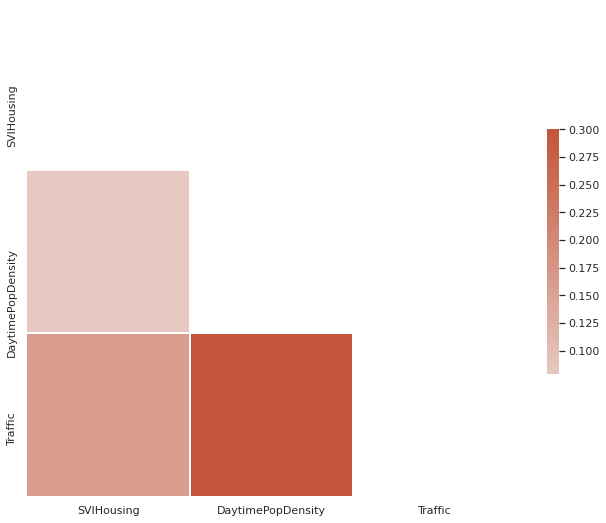

In [40]:
heatmap(df[grouped['PopConcentration']])

<AxesSubplot:>

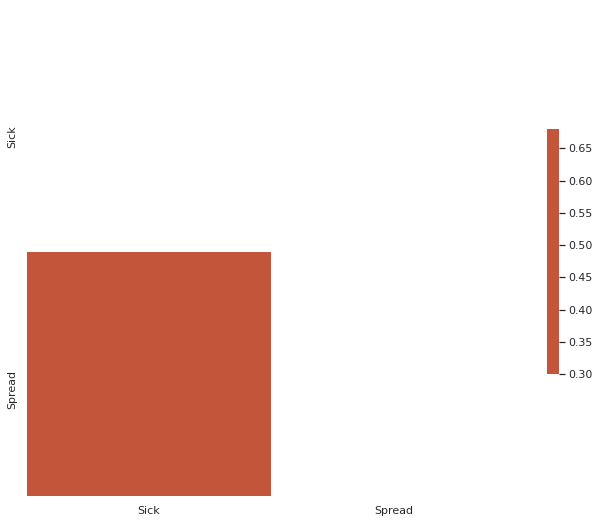

In [41]:
heatmap(df[grouped['InfectionRate']])

<AxesSubplot:>

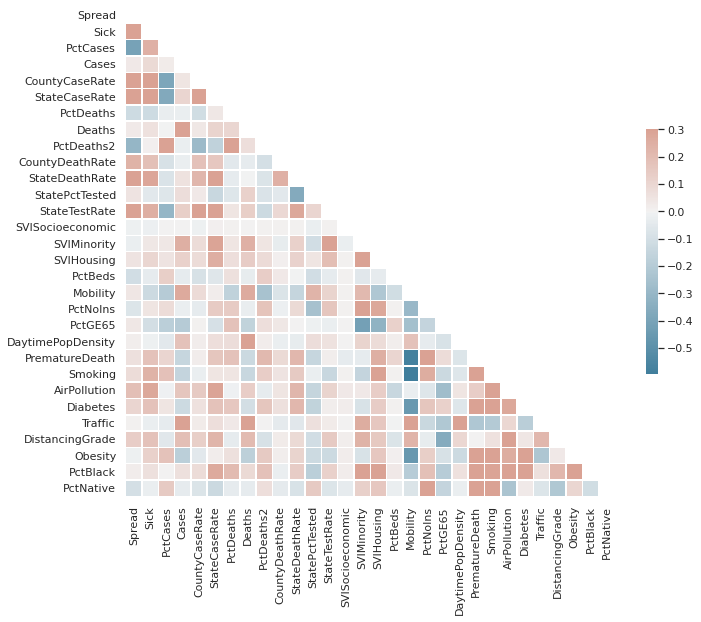

In [42]:
heatmap(df)

In [43]:
#print(getCronbachCombos(2))
'''{('Spread', 'Sick'): 0.8091354004545548, ('Spread', 'CountyCaseRate'): 0.9050995273320892, ('Spread', 'StateCaseRate'): 0.7315131140559525, ('Sick', 'CountyCaseRate'): 0.7034071837363033, ('Cases', 'Deaths'): 0.9391924626616269, ('CountyCaseRate', 'StateCaseRate'): 0.7186717205111317, ('StateCaseRate', 'StateTestRate'): 0.8154234445390387, ('PctDeaths', 'PctDeaths2'): 0.8794181673913716, ('Deaths', 'Traffic'): 0.7412877611705692, ('PrematureDeath', 'Smoking'): 0.8007708401199805}'''

"{('Spread', 'Sick'): 0.8091354004545548, ('Spread', 'CountyCaseRate'): 0.9050995273320892, ('Spread', 'StateCaseRate'): 0.7315131140559525, ('Sick', 'CountyCaseRate'): 0.7034071837363033, ('Cases', 'Deaths'): 0.9391924626616269, ('CountyCaseRate', 'StateCaseRate'): 0.7186717205111317, ('StateCaseRate', 'StateTestRate'): 0.8154234445390387, ('PctDeaths', 'PctDeaths2'): 0.8794181673913716, ('Deaths', 'Traffic'): 0.7412877611705692, ('PrematureDeath', 'Smoking'): 0.8007708401199805}"

In [44]:
#print(getCronbachCombos(3, sig = .8))
'''
{('Spread', 'Sick', 'CountyCaseRate'): 0.8659482789183152, ('Spread', 'CountyCaseRate', 'StateCaseRate'): 0.8505016335290945, ('Cases', 'Deaths', 'Traffic'): 0.8440646760783626}'''

"\n{('Spread', 'Sick', 'CountyCaseRate'): 0.8659482789183152, ('Spread', 'CountyCaseRate', 'StateCaseRate'): 0.8505016335290945, ('Cases', 'Deaths', 'Traffic'): 0.8440646760783626}"

In [45]:
#print(getCronbachCombos(4, sig =.8))
'''{('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate'): 0.8492502760812783, ('Spread', 'Sick', 'CountyCaseRate', 'StateTestRate'): 0.8148465401092174, ('Spread', 'CountyCaseRate', 'StateCaseRate', 'StateDeathRate'): 0.8006731378650762, ('Spread', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate'): 0.8479341497823013}'''

"{('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate'): 0.8492502760812783, ('Spread', 'Sick', 'CountyCaseRate', 'StateTestRate'): 0.8148465401092174, ('Spread', 'CountyCaseRate', 'StateCaseRate', 'StateDeathRate'): 0.8006731378650762, ('Spread', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate'): 0.8479341497823013}"

In [46]:
#print(getCronbachCombos(5, sig =.8))
'''{('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateDeathRate'): 0.823958213819909, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate'): 0.8489285421964142, ('Spread', 'CountyCaseRate', 'StateCaseRate', 'StateDeathRate', 'StateTestRate'): 0.8229852795147247}'''

"{('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateDeathRate'): 0.823958213819909, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate'): 0.8489285421964142, ('Spread', 'CountyCaseRate', 'StateCaseRate', 'StateDeathRate', 'StateTestRate'): 0.8229852795147247}"

In [47]:
#print(getCronbachCombos(6, sig =.8))
'''{('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'CountyDeathRate', 'StateTestRate'): 0.8065113240464071, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateDeathRate', 'StateTestRate'): 0.836373766459027, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate', 'SVIMinority'): 0.8015365518588273, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate', 'AirPollution'): 0.8136252537494238, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate', 'DistancingGrade'): 0.8049601656289115}'''

"{('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'CountyDeathRate', 'StateTestRate'): 0.8065113240464071, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateDeathRate', 'StateTestRate'): 0.836373766459027, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate', 'SVIMinority'): 0.8015365518588273, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate', 'AirPollution'): 0.8136252537494238, ('Spread', 'Sick', 'CountyCaseRate', 'StateCaseRate', 'StateTestRate', 'DistancingGrade'): 0.8049601656289115}"

In [78]:
queryToPandas("""
SELECT 
    name, 
    PctDeaths,
    PctDeaths2,
    Deaths
FROM 
    dataJ15 
WHERE 
    PctDeaths IS NULL
    OR PctDeaths2 IS NULL
    OR Deaths = 0
""")

,name,PctDeaths,PctDeaths2,Deaths
0,"Alaska, Aleutians East",0.0,0.0,0
1,"Alaska, Aleutians West",0.0,0.0,0
2,"Alaska, Bristol Bay",NaN,NaN,0
3,"Alaska, Denali",0.0,0.0,0
4,"Alaska, Haines",0.0,0.0,0
...,...,...,...,...
79,"Virginia, Highland",0.0,0.0,0
80,"Washington, San Juan",0.0,0.0,0
81,"Washington, Wahkiakum",0.0,0.0,0
82,"West Virginia, Calhoun",0.0,0.0,0


In [49]:
def tTest(indicator,interest='Deaths'):
    df_above = queryToPandas(f"""
    SELECT 
        * 
    FROM
        dataJ15
    WHERE 
        {indicator} > (SELECT AVG({indicator}) FROM dataJ15)
    """)
    df_below = queryToPandas(f"""
    SELECT 
        * 
    FROM
        dataJ15
    WHERE 
        {indicator} < (SELECT AVG({indicator}) FROM dataJ15)
    """)
    #Two independent sample ttest: 
    #H0: mean(interest | indicator abv average) = mean(interest | indicator bel average)
    #HA: mean(interest | indicator abv average) != mean(interest | indicator bel average)
    return stats.ttest_ind(df_above[interest],df_below[interest])

In [50]:
tTest('Obesity')

Ttest_indResult(statistic=-7.261878671747032, pvalue=4.7913971959823e-13)

In [85]:
for indicator in grouped['Health&Environment']:
    print(indicator + ' : ' + str(tTest(indicator,'PctCases')))

SVISocioeconomic : Ttest_indResult(statistic=0.9371375747332894, pvalue=0.34875986719356755)
PctBeds : Ttest_indResult(statistic=7.135331637439762, pvalue=1.2606417124255165e-12)
PctNoIns : Ttest_indResult(statistic=2.685170685848549, pvalue=0.007287394248014754)
PctGE65 : Ttest_indResult(statistic=-7.080244870904477, pvalue=1.7678683788894673e-12)
PrematureDeath : Ttest_indResult(statistic=2.6778493042960845, pvalue=0.0074489620525562536)
Smoking : Ttest_indResult(statistic=4.387095033015866, pvalue=1.186542420395561e-05)
AirPollution : Ttest_indResult(statistic=0.298417164544176, pvalue=0.7654047517184783)
Diabetes : Ttest_indResult(statistic=1.6634625773816125, pvalue=0.09631966678787666)
Obesity : Ttest_indResult(statistic=7.515855154823907, pvalue=7.332064488888802e-14)
PctBlack : Ttest_indResult(statistic=-1.8157020978059846, pvalue=0.06951142055017348)
PctNative : Ttest_indResult(statistic=4.560180129949833, pvalue=5.306394055634314e-06)


In [86]:
for indicator in grouped['Intervention']:
    print(indicator + ' : ' + str(tTest(indicator,'PctCases')))

StatePctTested : Ttest_indResult(statistic=0.8754919997030969, pvalue=0.381373225342616)
DistancingGrade : Ttest_indResult(statistic=-1.3538887205253967, pvalue=0.17587212635411495)


In [87]:
for indicator in grouped['InfectionRate']:
    print(indicator + ' : ' + str(tTest(indicator,'PctCases')))

Sick : Ttest_indResult(statistic=12.018567641368099, pvalue=1.4624519377245364e-32)
Spread : Ttest_indResult(statistic=-21.041718993520217, pvalue=4.8875801975060746e-92)


In [88]:
for indicator in grouped['PopConcentration']:
    print(indicator + ' : ' + str(tTest(indicator,'PctCases')))

SVIHousing : Ttest_indResult(statistic=2.245564205792343, pvalue=0.024801228316499325)
DaytimePopDensity : Ttest_indResult(statistic=-6.169106102334719, pvalue=7.74606075850626e-10)
Traffic : Ttest_indResult(statistic=-2.2891166010429753, pvalue=0.0221386687424779)


In [55]:
allCols = ['Spread', 'Sick', 'PctCases', 'Cases', 'CountyCaseRate', 'StateCaseRate', 
                            'PctDeaths','Deaths', 'PctDeaths2', 'CountyDeathRate', 'StateDeathRate', 'StatePctTested',
                            'StateTestRate', 'SVISocioeconomic', 'SVIMinority', 'SVIHousing', 'PctBeds', 'Mobility',
                            'PctNoIns', 'PctGE65', 'DaytimePopDensity', 'PrematureDeath', 'Smoking', 'AirPollution', 
                            'Diabetes', 'Traffic', 'DistancingGrade', 'Obesity', 'PctBlack', 'PctNative']
for indicator in allCols:
    print(indicator + ' : ' + str(tTest(indicator)))

Spread : Ttest_indResult(statistic=3.146106435460979, pvalue=0.0016701468194752717)
Sick : Ttest_indResult(statistic=2.463187272812381, pvalue=0.013824240938962442)
PctCases : Ttest_indResult(statistic=-0.8903353136157722, pvalue=0.37335407455394687)
Cases : Ttest_indResult(statistic=25.10591111153958, pvalue=6.44635355887404e-127)
CountyCaseRate : Ttest_indResult(statistic=4.244776213317656, pvalue=2.2518294384839243e-05)
StateCaseRate : Ttest_indResult(statistic=5.450847047592073, pvalue=5.400738226387269e-08)
PctDeaths : Ttest_indResult(statistic=3.6493746436425774, pvalue=0.0002671633450843627)
Deaths : Ttest_indResult(statistic=26.770886389154164, pvalue=2.1999078346152832e-142)
PctDeaths2 : Ttest_indResult(statistic=3.897312887511672, pvalue=9.929935797265648e-05)
CountyDeathRate : Ttest_indResult(statistic=-1.9936318157773734, pvalue=0.046281484878887925)
StateDeathRate : Ttest_indResult(statistic=-1.987912007379823, pvalue=0.0469081288322618)
StatePctTested : Ttest_indResult(st

In [56]:
for indicator in allCols:
    print(indicator + ' : ' + str(tTest(indicator,'Cases')))

Spread : Ttest_indResult(statistic=3.326246725941036, pvalue=0.0008904070161926222)
Sick : Ttest_indResult(statistic=3.5791624203675205, pvalue=0.00034992968644037125)
PctCases : Ttest_indResult(statistic=1.2097770859820025, pvalue=0.22645551070977762)
Cases : Ttest_indResult(statistic=26.599063044603827, pvalue=9.286542029586915e-141)
CountyCaseRate : Ttest_indResult(statistic=4.148997048973891, pvalue=3.428411645793434e-05)
StateCaseRate : Ttest_indResult(statistic=4.429798076654401, pvalue=9.754341269056551e-06)
PctDeaths : Ttest_indResult(statistic=-2.510386758582642, pvalue=0.012109836901114902)
Deaths : Ttest_indResult(statistic=26.57861627235001, pvalue=1.448246689017676e-140)
PctDeaths2 : Ttest_indResult(statistic=-1.4301568349264209, pvalue=0.1527716003333521)
CountyDeathRate : Ttest_indResult(statistic=-0.33727419079544924, pvalue=0.7359334901765926)
StateDeathRate : Ttest_indResult(statistic=0.4287076968658894, pvalue=0.6681653660290545)
StatePctTested : Ttest_indResult(stat

In [79]:
for indicator in allCols:
    print(indicator + ' : ' + str(tTest(indicator,'PctCases')))

Spread : Ttest_indResult(statistic=-21.041718993520217, pvalue=4.8875801975060746e-92)
Sick : Ttest_indResult(statistic=12.018567641368099, pvalue=1.4624519377245364e-32)
PctCases : Ttest_indResult(statistic=65.5739023340143, pvalue=0.0)
Cases : Ttest_indResult(statistic=0.020941252010761486, pvalue=0.983293850033602)
CountyCaseRate : Ttest_indResult(statistic=-21.920296940624386, pvalue=3.4516082177360976e-99)
StateCaseRate : Ttest_indResult(statistic=-18.50306793185114, pvalue=1.2390190005652598e-72)
PctDeaths : Ttest_indResult(statistic=-0.5462268489066004, pvalue=0.5849488565374334)
Deaths : Ttest_indResult(statistic=-1.395971690844534, pvalue=0.16282170871537688)
PctDeaths2 : Ttest_indResult(statistic=22.65743093226274, pvalue=2.1797148015940075e-105)
CountyDeathRate : Ttest_indResult(statistic=-3.578994432973075, pvalue=0.0003503077242750617)
StateDeathRate : Ttest_indResult(statistic=-2.779717410323178, pvalue=0.005473023027577745)
StatePctTested : Ttest_indResult(statistic=0.87

<AxesSubplot:>

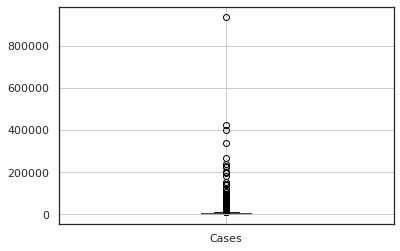

In [71]:
queryToPandas(f"""
    SELECT 
        Cases
    FROM
        dataJ15
    WHERE 
        Smoking < (SELECT AVG(Smoking) FROM dataJ15)
    """).boxplot('Cases')


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Spread             3129 non-null   float64
 1   Sick               3132 non-null   float64
 2   PctCases           3142 non-null   float64
 3   Cases              3142 non-null   int32  
 4   CountyCaseRate     3126 non-null   float64
 5   StateCaseRate      3142 non-null   float64
 6   PctDeaths          3139 non-null   float64
 7   Deaths             3142 non-null   int32  
 8   PctDeaths2         3139 non-null   float64
 9   CountyDeathRate    3043 non-null   float64
 10  StateDeathRate     3142 non-null   float64
 11  StatePctTested     3142 non-null   float64
 12  StateTestRate      3142 non-null   float64
 13  SVISocioeconomic   3142 non-null   float64
 14  SVIMinority        3142 non-null   float64
 15  SVIHousing         3142 non-null   float64
 16  PctBeds            2493 